Recordar consultar el [Diccionario de datos](./Datasets/Google%20Maps/Diccionario%20de%20datos.docx)


# Importaciones


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Llamado de datos a dataframes


In [2]:
df_maps_restaurantes = pd.read_parquet(r"Generated\Google\metada_sitios.parquet")
df_maps_reviews = pd.read_parquet(r"Generated\Google\merge_site_reviews.parquet")
df_yelp_restaurantes = pd.read_parquet(r"Generated\Yelp\bussines.parquet")
df_yelp_checkin = pd.read_parquet(r"Generated\YELP\business_checkin.parquet")
df_yelp_tips = pd.read_parquet(r"Generated\Yelp\business_tip.parquet")
df_yelp_reviews = pd.read_parquet(r"Generated\Yelp\review.parquet")
df_yelp_users = pd.read_parquet(r"Generated\Yelp\users_extracted.parquet")

### Subway

es la empresa con la que trabajaremos, empezaremos por ver cuantos registros hay en cada Dataframe


In [3]:
subway_records_rest = df_yelp_restaurantes.loc[df_yelp_restaurantes["name"] == "Subway"]
count_subway_records_rest = subway_records_rest.shape[0]
print("Número de registros de Subway en restaurantes:", count_subway_records_rest)

Número de registros de Subway en restaurantes: 227


In [4]:
subway_records_checkin = df_yelp_checkin.loc[df_yelp_checkin["name"] == "Subway"]
count_subway_records_checkin = subway_records_checkin.shape[0]
print("Número de registros de Subway en checkin:", count_subway_records_checkin)

Número de registros de Subway en checkin: 7


In [5]:
subway_records_tips = df_yelp_tips.loc[df_yelp_tips["name"] == "Subway"]
count_subway_records_tips = subway_records_tips.shape[0]
print("Número de registros de Subway tips:", count_subway_records_tips)

Número de registros de Subway tips: 79


Para revisar el dataframe de reviews y el de usuarios, deberemos obtener el Business_id y usarlo de guía

Para eso, crearemos una lista que contenga todos los business_id que correspondan a locales de Subway, luego crearemos un dataframe que contenga todas las reviews de subway y uno que contenga todos los usuarios que realizaron reviews


In [6]:
(df_yelp_restaurantes.loc[df_yelp_restaurantes["name"] == "Subway"]).head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
964,vuL3QCjFZ7lU5LMdUAmZ9Q,Subway,383 W Lancaster Ave,Wayne,FL,19087,40.044263,-75.399354,1.5,5,0,None,"Sandwiches, Fast Food, Restaurants",None


In [7]:
subway_business_ids = df_yelp_restaurantes.loc[
    df_yelp_restaurantes["name"] == "Subway", "business_id"
].tolist()
len(subway_business_ids)

227

In [8]:
reviews_yelp_subway = df_yelp_reviews[
    df_yelp_reviews["business_id"].isin(subway_business_ids)
]
reviews_yelp_subway

,review_id,user_id,business_id,stars,funny,cool,text,date
598,CEHaucuAzqSzOdMB3mPNTA,jsej79maZJg_X619aw8dig,1QtF1bFgzG3Jo0-L4kv0Cg,2,0,0,This place was slow and didn't have any deals ...,2017-10-24 21:40:04
6462,3kLKI7hBik4xKy_FUPXXTQ,uZ_F1KUH5V04eMBYEXr6Xw,wXBAAafoiZ4Nty2ajuBtfw,4,1,1,I don't normally review fast-food chains but I...,2017-08-02 15:38:51
7365,CYK_xEubeGE6fxwwwZqiyA,YazB4ROLMQ6-jvDfumvijA,zJdQwRbI7p0bH_60sfBSYA,5,0,0,This Subway location knows how to handle their...,2017-05-03 07:21:13
9586,0pgkcbEjVNbRdN8BWgYSdg,KG8SNh9SITNPrGa6IdQcsg,DfkO7MHuy2wxgeUZ2-o3BA,1,0,0,We actually went to the subway at 204 St. Char...,2017-04-03 17:47:37
11232,E1UPtQToxHDJlA9SBnft1w,0DK-fg2ZBnpkMKnU9SgPMQ,qBvsNlxtqy8hPxx1C7HuVA,4,1,3,I never realized there was a subway this close...,2017-04-13 15:25:21
...,...,...,...,...,...,...,...,...
541804,uz00Jmfo94oHYmNQNcNq_g,aOiElbImAVfYUulkyrnnqA,-x-niT6JolhXi6VuKclgxw,1,0,0,Usually this place is good when the younger gi...,2019-04-24 05:44:59
543833,h2oZkwhsOTmJtfbkNeBnew,QqTZgY7Kx1-fec-IFSKqMA,F0QWKYUmBkxWOap1xspVzw,1,1,1,Omg gross!!! Whats the point of washing your h...,2017-09-02 02:18:34
544036,qrKB3TcNYh0OP45jK-Suvw,3R_WZTTbbAV9zbkwvEAIsw,F0QWKYUmBkxWOap1xspVzw,2,0,0,"Sandwhiches, are as good as subway can make th...",2018-03-06 17:16:30
549237,4MXcgkYsGOycBy2LWBHRsg,ffNVkYsl23SMCKKW6u923A,cdbEEL_0TLOPgdfsB3PUvA,4,1,1,Ate there today good service and fresh food. T...,2019-06-16 01:11:10


Ahora, obtendremos los usuarios

Para hacer esto, obtendremos los user_id de nuestro recien creado **reviews_yelp_subway** y los usaremos como filtro para obtener los usuarios que han cualificado a algun local de subway, ademas, agregaremos una columna que contara cuantas reviews han hecho a subway


In [9]:
df_yelp_users.head(1)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,elite_len
0,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,184,157,251,1847,7054,3131,3131,1521,1946,14


In [10]:
unique_user_ids = reviews_yelp_subway["user_id"].unique()
filtered_users = df_yelp_users[df_yelp_users["user_id"].isin(unique_user_ids)]
subway_count = (
    reviews_yelp_subway.groupby("user_id").size().reset_index(name="subway_count")
)
yelp_users_subway = filtered_users.merge(subway_count, on="user_id", how="left")
yelp_users_subway["subway_count"] = yelp_users_subway["subway_count"].fillna(0)
yelp_users_subway.head(1)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,elite_len,subway_count
0,EvJ1yXjsBqK_NH493WdA6A,Kate,171,2010-02-14 00:51:06,288,24,143,"[2011, 2012, 2013, 2014, 2015, 2016, 2017, 201...","7K4SzSIG9zUzBLCh0gHNjA, s5txUZuoj4gNHQ3UY9Dnrg...",15,...,0,0,19,25,38,38,11,3,9,1


# Outlieers


## df_yelp_checkin

Se realiza un boxplot de la puntiación de estrellas y de la cantidad de reviews para visualizar posibles outliers


In [11]:
df_yelp_checkin.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,date
0,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Eatertainment, Arts & Entertainment, Brewpubs,...","{'Friday': '16:0-19:0', 'Monday': '0:0-0:0', '...","2019-03-09 17:44:26, 2019-03-16 23:26:17, 2019..."


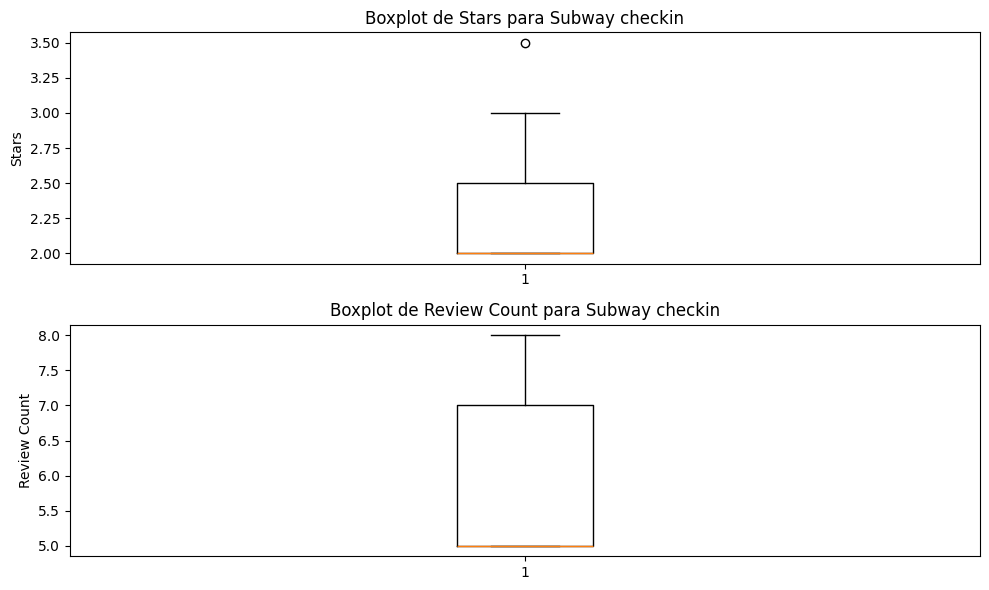

In [12]:
subway_data_checkin = df_yelp_checkin[df_yelp_checkin["name"] == ("Subway")]

plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.boxplot(subway_data_checkin["stars"])
plt.title("Boxplot de Stars para Subway checkin")
plt.ylabel("Stars")

plt.subplot(2, 1, 2)
plt.boxplot(subway_data_checkin["review_count"])
plt.title("Boxplot de Review Count para Subway checkin")
plt.ylabel("Review Count")

plt.tight_layout()
plt.show()

In [13]:
df_yelp_checkin[
    (df_yelp_checkin["name"] == "Subway") & (df_yelp_checkin["stars"] == 3.5)
]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,date
1712,Om6OwVsJ_t2XHQBYKnlcHg,Subway,10551 Kingsway Avenue,Edmonton,PA,T5H 4K1,53.557377,-113.502513,3.5,5,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Fast Food, Sandwiches, Restaurants","{'Friday': '9:0-22:0', 'Monday': '9:0-22:0', '...",2019-09-09 02:37:26


Vamos a quitar todas aquellas categorias que solo se repiten una vez, pero primero vamos a recorrerlas para tener una noción de lo que tratan


In [14]:
categorias = df_yelp_checkin["categories"].tolist()
categorias_separadas = [categoria.split(", ") for categoria in categorias]
todas_categorias = [item for sublist in categorias_separadas for item in sublist]
frecuencia_categorias = {
    categoria: todas_categorias.count(categoria) for categoria in set(todas_categorias)
}
categorias_menos_comunes = sorted(frecuencia_categorias.items(), key=lambda x: x[1])
menos_repetidas = categorias_menos_comunes[:89]

print("Las menos repetidas son:")
for categoria, frecuencia in menos_repetidas:
    print(f"{categoria}: {frecuencia} veces")

Las menos repetidas son:
Cinema: 1 veces
Landscaping: 1 veces
Gyms: 1 veces
Towing: 1 veces
Amusement Parks: 1 veces
Self Storage: 1 veces
Waxing: 1 veces
Izakaya: 1 veces
Egyptian: 1 veces
Herbal Shops: 1 veces
Junk Removal & Hauling: 1 veces
Shaved Snow: 1 veces
Adult Education: 1 veces
Cosmetic Surgeons: 1 veces
Pet Sitting: 1 veces
Bookstores: 1 veces
Pop-up Shops: 1 veces
Plastic Surgeons: 1 veces
Scandinavian: 1 veces
Tasting Classes: 1 veces
Traditional Chinese Medicine: 1 veces
Golf Equipment: 1 veces
Golf Lessons: 1 veces
Office Cleaning: 1 veces
Parking: 1 veces
Comic Books: 1 veces
Syrian: 1 veces
Packing Services: 1 veces
Wine Tasting Room: 1 veces
Pharmacy: 1 veces
Yoga: 1 veces
Guamanian: 1 veces
Wine Tasting Classes: 1 veces
Head Shops: 1 veces
Beer Tours: 1 veces
Barbers: 1 veces
Souvenir Shops: 1 veces
Boating: 1 veces
LAN Centers: 1 veces
Social Clubs: 1 veces
Team Building Activities: 1 veces
Speakeasies: 1 veces
Dumplings: 1 veces
Hunting & Fishing Supplies: 1 veces

Al ser obsoletas todos, prodecemos a su extracción


In [15]:
categorias = df_yelp_checkin["categories"].str.split(", ").explode()

frecuencia_categorias = categorias.value_counts()

categorias_solo_una_vez = frecuencia_categorias[
    frecuencia_categorias == 1
].index.tolist()


def filtrar_categorias(categoria_str):
    categorias_lista = categoria_str.split(", ")
    categorias_filtradas = [
        categoria
        for categoria in categorias_lista
        if categoria not in categorias_solo_una_vez
    ]
    return ", ".join(categorias_filtradas)


df_yelp_checkin["categories"] = df_yelp_checkin["categories"].apply(filtrar_categorias)

print("DataFrame modificado eliminando las categorías que se repiten solo una vez:")
df_yelp_checkin.head()

DataFrame modificado eliminando las categorías que se repiten solo una vez:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,date
0,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Eatertainment, Arts & Entertainment, Brewpubs,...","{'Friday': '16:0-19:0', 'Monday': '0:0-0:0', '...","2019-03-09 17:44:26, 2019-03-16 23:26:17, 2019..."
1,lk9IwjZXqUMqqOhM774DtQ,Caviar & Bananas,2031 Broadway,Nashville,PA,37203,36.148371,-86.798895,3.5,159,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Coffee & Tea, Restaurants, Wine Bars, Bars, Ni...","{'Friday': '7:0-17:0', 'Monday': '7:0-17:0', '...","2017-06-18 17:23:58, 2017-06-20 23:47:06, 2017..."
2,cVBxfMC4lp3DnocjYA3FHQ,Paws The Cat Cafe,10588 109 Street,Edmonton,FL,T5H 3B2,53.549633,-113.508780,5.0,20,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Coffee & Tea, Cafes, Pets, Restaurants, Pet Ad...","{'Friday': '10:0-20:0', 'Monday': '0:0-0:0', '...","2017-11-30 19:49:29, 2018-01-23 22:10:48, 2018..."
3,pJfh3Ct8iL58NZa8ta-a5w,Top Shelf Sports Lounge,3173 Cypress Ridge Blvd,Wesley Chapel,PA,33544,28.196252,-82.380615,4.5,95,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Burgers, Sports Bars, Bars, Lounges, Restauran...","{'Friday': '11:30-23:30', 'Monday': '11:30-22:...","2018-02-09 22:40:05, 2018-03-25 21:01:21, 2018..."
4,YNjyv0gfOr2g8lbmUpTnKg,Copper Vine,1001 Poydras St,New Orleans,PA,70112,29.950647,-90.074427,4.5,350,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Nightlife, Pubs, Event Planning & Services, Wi...","{'Friday': '11:0-23:0', 'Monday': '0:0-0:0', '...","2018-08-31 19:34:29, 2018-09-05 22:46:19, 2018..."


repetimos el mismo proceso parra **df_yelp_restaurantes**


In [16]:
subway_rest_data = df_yelp_restaurantes.loc[df_yelp_restaurantes["name"] == "Subway"]

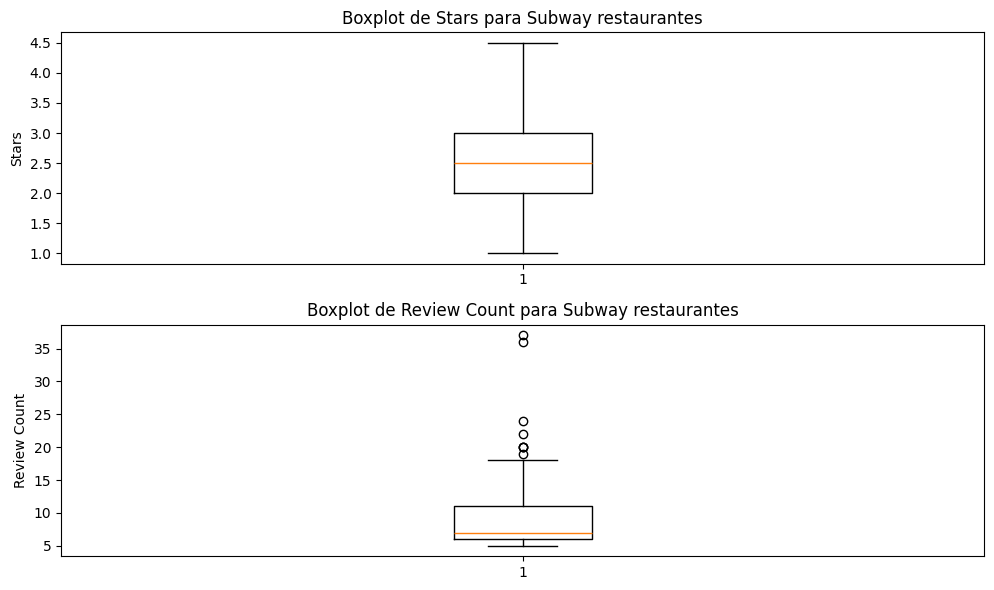

In [17]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.boxplot(subway_rest_data["stars"])
plt.title("Boxplot de Stars para Subway restaurantes")
plt.ylabel("Stars")

plt.subplot(2, 1, 2)
plt.boxplot(subway_rest_data["review_count"])
plt.title("Boxplot de Review Count para Subway restaurantes")
plt.ylabel("Review Count")

plt.tight_layout()
plt.show()

In [18]:
df_yelp_restaurantes[
    (df_yelp_restaurantes["name"] == "Subway")
    & (df_yelp_restaurantes["review_count"] > 15)
]

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
13826,d-hMYlJ-hMAHSgd3KvYcWg,Subway,465 E Plumb Ln,Reno,FL,89511,39.506015,-119.797213,2.5,24,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Food Delivery Services, Restaurants, Delis, Sa...","{'Friday': '9:0-21:30', 'Monday': '9:0-21:30',..."
13894,EwblShAzTJ4Op6aJZYYuVA,Subway,"1641 S Jefferson Ave, Ste E",St. Louis,PA,63104,38.615624,-90.221256,2.5,16,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Sandwiches, Restaurants, Fast Food","{'Friday': '9:0-21:0', 'Monday': '0:0-0:0', 'S..."
23139,CyctXClhoy8YamJjcE2ifg,Subway,5530 Telegraph Rd,St Louis,FL,63129,38.471225,-90.304188,1.5,22,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Fast Food, Sandwiches, Restaurants","{'Friday': '10:30-19:0', 'Monday': '10:30-19:0..."
40209,lF7Zn9GNg0wMpM5g5kWdBw,Subway,5015 S Mccarran Blvd,Reno,CA,89502,39.477285,-119.783929,2.5,36,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Sandwiches, Fast Food, Restaurants","{'Friday': '7:0-17:0', 'Monday': '0:0-0:0', 'S..."
40714,3p1gTXaVUKprXnzvhq7RRA,Subway,"5055 Sun Valley Blvd, Ste 300",Sun Valley,FL,89433,39.576861,-119.781463,2.0,19,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Fast Food, Restaurants, Sandwiches","{'Friday': '10:0-21:0', 'Monday': '10:0-20:30'..."
42625,An_QUi1YfPUf5kXJEgZMeQ,Subway,"5480 E Speedway Blvd, Ste C102",Tucson,FL,85712,32.235828,-110.875841,3.0,18,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Sandwiches, Fast Food","{'Friday': '7:0-18:0', 'Monday': '0:0-0:0', 'S..."
47599,mwRqQENSKmBIGZEfWRzX5g,Subway,"6688 Nolensville Pike Rd, Ste 212",Brentwood,FL,37027,36.000563,-86.692133,1.5,20,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Fast Food, Sandwiches","{'Friday': '9:0-21:0', 'Monday': '0:0-0:0', 'S..."
53630,9_DJMSzn5PtMit78KFrwaw,Subway,237 N Peters,New Orleans,PA,70130,29.953171,-90.065352,2.5,18,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Sandwiches, Fast Food","{'Friday': '9:0-18:30', 'Monday': '9:0-18:30',..."
66109,7e4PHzKqvtxcbxcXy6Jn3g,Subway,1151 S Kingshighway Blvd,St Louis,PA,63110,38.627035,-90.265107,2.5,20,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Sandwiches, Fast Food","{'Friday': '10:0-20:0', 'Monday': '10:0-20:0',..."
75582,2qg67Mq6cKjl1GPbls32Dg,Subway,"1131 Steamboat Pkwy, Ste 800",Reno,FL,89521,39.423295,-119.738617,3.0,37,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Sandwiches, Fast Food","{'Friday': '10:0-19:0', 'Monday': '10:0-19:0',..."


Eliminacion de etiquetas de categoría obsoletos


In [19]:
categorias = df_yelp_restaurantes["categories"].tolist()
categorias_separadas = [categoria.split(", ") for categoria in categorias]
todas_categorias = [item for sublist in categorias_separadas for item in sublist]
frecuencia_categorias = {
    categoria: todas_categorias.count(categoria) for categoria in set(todas_categorias)
}
categorias_menos_comunes = sorted(frecuencia_categorias.items(), key=lambda x: x[1])
menos_repetidas = categorias_menos_comunes[:167]

print("Las menos repetidas son:")
for categoria, frecuencia in menos_repetidas:
    print(f"{categoria}: {frecuencia} veces")

Las menos repetidas son:
Musical Instruments & Teachers: 1 veces
Real Estate Law: 1 veces
Appliances & Repair: 1 veces
Serbo Croatian: 1 veces
Watches: 1 veces
Drive-In Theater: 1 veces
Piercing: 1 veces
Outlet Stores: 1 veces
Pet Groomers: 1 veces
Osteopaths: 1 veces
Dentists: 1 veces
Roadside Assistance: 1 veces
Hiking: 1 veces
Landscaping: 1 veces
Radio Stations: 1 veces
Towing: 1 veces
Apartments: 1 veces
Oil Change Stations: 1 veces
Fishing: 1 veces
Pita: 1 veces
Hotel bar: 1 veces
Dietitians: 1 veces
Boat Repair: 1 veces
Botanical Gardens: 1 veces
Car Dealers: 1 veces
Homeowner Association: 1 veces
Music & DVDs: 1 veces
Oriental: 1 veces
Battery Stores: 1 veces
Carpet Cleaning: 1 veces
Outdoor Gear: 1 veces
Animal Shelters: 1 veces
Reiki: 1 veces
Tree Services: 1 veces
Fuzhou: 1 veces
Go Karts: 1 veces
Cosmetic Surgeons: 1 veces
Used Bookstore: 1 veces
Haunted Houses: 1 veces
Wildlife Control: 1 veces
Tiling: 1 veces
Soccer: 1 veces
Solar Installation: 1 veces
Investing: 1 veces


In [20]:
categorias = df_yelp_restaurantes["categories"].str.split(", ").explode()

frecuencia_categorias = categorias.value_counts()

categorias_solo_una_vez = frecuencia_categorias[
    frecuencia_categorias == 1
].index.tolist()


def filtrar_categorias(categoria_str):
    categorias_lista = categoria_str.split(", ")
    categorias_filtradas = [
        categoria
        for categoria in categorias_lista
        if categoria not in categorias_solo_una_vez
    ]
    return ", ".join(categorias_filtradas)


df_yelp_restaurantes["categories"] = df_yelp_restaurantes["categories"].apply(
    filtrar_categorias
)

print("DataFrame modificado eliminando las categorías que se repiten solo una vez:")
df_yelp_restaurantes.head()

DataFrame modificado eliminando las categorías que se repiten solo una vez:


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '..."
14,0bPLkL0QhhPO5kt1_EXmNQ,Zio's Italian Market,2575 E Bay Dr,Largo,FL,33771,27.916116,-82.760461,4.5,100,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Food, Delis, Italian, Bakeries, Restaurants","{'Friday': '10:0-20:0', 'Monday': '10:0-18:0',..."
22,kfNv-JZpuN6TVNSO6hHdkw,Hibachi Express,6625 E 82nd St,Indianapolis,PA,46250,39.904320,-86.053080,4.0,20,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Steakhouses, Asian Fusion, Restaurants","{'Friday': '11:0-21:0', 'Monday': '11:0-21:0',..."
28,QdN72BWoyFypdGJhhI5r7g,Bar One,767 S 9th St,Philadelphia,PA,19147,39.939825,-75.157447,4.0,65,0,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Cocktail Bars, Bars, Italian, Nightlife, Resta...","{'Friday': '12:0-2:0', 'Monday': '16:0-0:0', '..."
29,sqSqqLy0sN8n2IZrAbzidQ,Domino's Pizza,3001 Highway 31 W,White House,CA,37188,36.464747,-86.659187,3.5,8,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Pizza, Chicken Wings, Sandwiches, Restaurants","{'Friday': '10:0-1:0', 'Monday': '10:0-0:0', '..."


Repetimos una vez mas el procedimiento pero esta vez con **_df_yelp_tips_**


In [21]:
subway_data_tips = df_yelp_tips[df_yelp_tips["name"] == "Subway"]

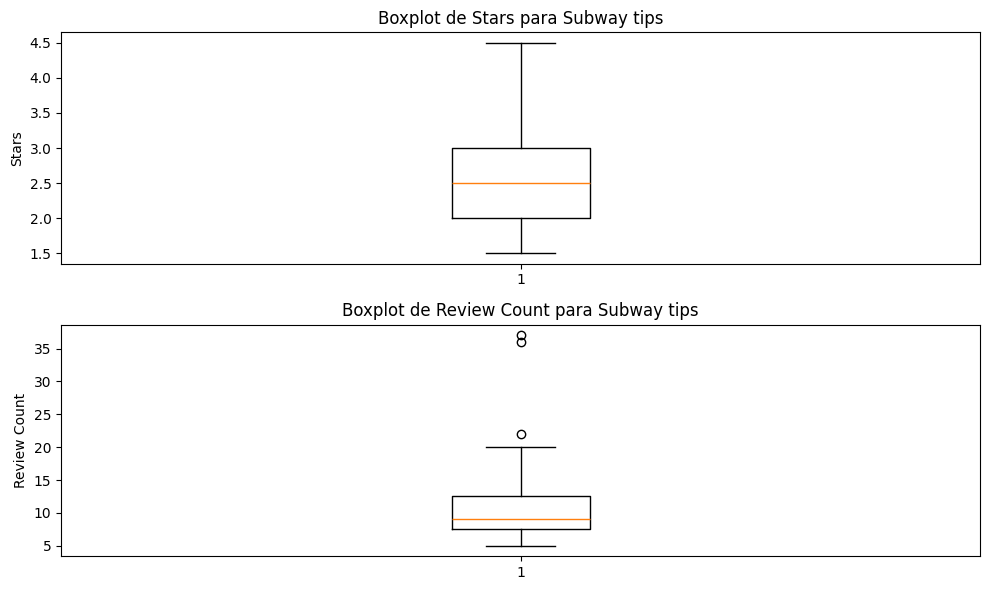

In [22]:
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.boxplot(subway_data_tips["stars"])
plt.title("Boxplot de Stars para Subway tips")
plt.ylabel("Stars")

plt.subplot(2, 1, 2)
plt.boxplot(subway_data_tips["review_count"])
plt.title("Boxplot de Review Count para Subway tips")
plt.ylabel("Review Count")

plt.tight_layout()
plt.show()

In [23]:
df_yelp_tips[(df_yelp_tips["name"] == "Subway") & (df_yelp_tips["review_count"] > 20)]

,user_id,business_id,text,date,compliment_count,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
52635,orB78QDImDsusooQud9hFw,2qg67Mq6cKjl1GPbls32Dg,Wow! Such amazing customer service. Great job ...,2019-09-05 20:12:50,0,Subway,"1131 Steamboat Pkwy, Ste 800",Reno,FL,89521,39.423295,-119.738617,3.0,37,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Sandwiches, Fast Food","{'Friday': '10:0-19:0', 'Monday': '10:0-19:0',..."
59529,xHVwBmvuBEbmV0c4NU2Hwg,CyctXClhoy8YamJjcE2ifg,The old owner was horrible. The new owner is a...,2018-09-16 17:42:52,0,Subway,5530 Telegraph Rd,St Louis,FL,63129,38.471225,-90.304188,1.5,22,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Fast Food, Sandwiches, Restaurants","{'Friday': '10:30-19:0', 'Monday': '10:30-19:0..."
63459,HT6tAhRKfcrqRb9T118HEA,lF7Zn9GNg0wMpM5g5kWdBw,Long line...went very fast! All were friendly!,2017-04-26 19:18:47,0,Subway,5015 S Mccarran Blvd,Reno,CA,89502,39.477285,-119.783929,2.5,36,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Sandwiches, Fast Food, Restaurants","{'Friday': '7:0-17:0', 'Monday': '0:0-0:0', 'S..."


Una vez mas, repetimos el proceso en las categorías


In [24]:
categorias = df_yelp_tips["categories"].tolist()
categorias_separadas = [categoria.split(", ") for categoria in categorias]
todas_categorias = [item for sublist in categorias_separadas for item in sublist]
frecuencia_categorias = {
    categoria: todas_categorias.count(categoria) for categoria in set(todas_categorias)
}
categorias_menos_comunes = sorted(frecuencia_categorias.items(), key=lambda x: x[1])
menos_repetidas = categorias_menos_comunes[:44]

print("Las menos repetidas son:")
for categoria, frecuencia in menos_repetidas:
    print(f"{categoria}: {frecuencia} veces")

Las menos repetidas son:
Musical Instruments & Teachers: 1 veces
Osteopaths: 1 veces
Radio Stations: 1 veces
Fishing: 1 veces
Contractors: 1 veces
Self Storage: 1 veces
Herbal Shops: 1 veces
Junk Removal & Hauling: 1 veces
Used Bookstore: 1 veces
Nicaraguan: 1 veces
Pop-up Shops: 1 veces
Building Supplies: 1 veces
Counseling & Mental Health: 1 veces
Kitchen Supplies: 1 veces
Packing Services: 1 veces
Guamanian: 1 veces
Wine Tasting Classes: 1 veces
Colleges & Universities: 1 veces
Motorcycle Dealers: 1 veces
Web Design: 1 veces
Hospitals: 1 veces
Trainers: 1 veces
Speakeasies: 1 veces
Medical Centers: 1 veces
Movers: 1 veces
Taxis: 1 veces
Damage Restoration: 1 veces
Car Share Services: 1 veces
Gun/Rifle Ranges: 1 veces
Spiritual Shop: 1 veces
Cultural Center: 1 veces
Departments of Motor Vehicles: 1 veces
Photographers: 1 veces
Airport Terminals: 1 veces
Rolfing: 1 veces
Guns & Ammo: 1 veces
Limos: 1 veces
Popcorn Shops: 1 veces
Mass Media: 1 veces
Session Photography: 1 veces
Trampol

In [25]:
categorias = df_yelp_tips["categories"].str.split(", ").explode()

frecuencia_categorias = categorias.value_counts()

categorias_solo_una_vez = frecuencia_categorias[
    frecuencia_categorias == 1
].index.tolist()


def filtrar_categorias(categoria_str):
    categorias_lista = categoria_str.split(", ")
    categorias_filtradas = [
        categoria
        for categoria in categorias_lista
        if categoria not in categorias_solo_una_vez
    ]
    return ", ".join(categorias_filtradas)


df_yelp_tips["categories"] = df_yelp_tips["categories"].apply(filtrar_categorias)

print("DataFrame modificado eliminando las categorías que se repiten solo una vez:")
df_yelp_tips.head()

DataFrame modificado eliminando las categorías que se repiten solo una vez:


,user_id,business_id,text,date,compliment_count,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1viszljzsa8W7VnYPuWosw,Zg83olSjsdXAhE5EEy5IcQ,Order crispy and they bake it up good.,2018-04-01 01:40:12,0,Oregano's,100 W Orange Grove Rd,Tucson,PA,85704,32.323157,-110.973652,3.5,385,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Italian, Pizza","{'Friday': '11:0-22:0', 'Monday': '0:0-0:0', '..."
1,YnlCpuaBa3qWBp4te8pGmA,XIKYdKWq72zUYsq8NBxcCQ,The honey glazed salmon is amazing!,2018-01-14 15:00:01,0,Aksum Cafe,4630 Baltimore Ave,Philadelphia,PA,19143,39.948547,-75.216366,4.0,393,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Mediterranean, Vegetarian, American (New), Res...","{'Friday': '16:0-21:0', 'Monday': '0:0-0:0', '..."
2,IE0f4Mt6rfEw26pn598doA,aPD0HkuA7MXNhZZqXiGF4g,Great fish and chips!!,2017-09-30 22:39:11,0,McCreary's Irish Pub and Eatery,414 Main St,Franklin,PA,37064,35.924479,-86.870951,3.5,146,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Pubs, Bars, Irish Pub, Irish, American (New), ...","{'Friday': '11:0-23:0', 'Monday': '11:0-22:0',..."
3,BrobnxoTkPml180NhXl6kw,zjLT8ELDYxxknQ9ZLrl6_w,Call ahead of time to make sure there isn't a ...,2017-03-18 18:22:28,0,Brunchery Restaurant & Catering,"3225 S MacDill Ave, Ste 109",Tampa,PA,33629,27.915901,-82.494764,3.5,274,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Caterers, Sandwiches, Burgers, Ev...","{'Friday': '7:0-14:0', 'Monday': '7:0-14:0', '..."
4,9XhCRgu_v7y-X2v4Av3HPA,fgnHM4VT-n1VjFL3YeBJsg,Ordered the pad Thai shrimp and it was good!,2017-08-29 17:12:23,0,Royal Thai Bistreaux,"1299 Hickory Ave, Ste A",Harahan,PA,70123,29.956544,-90.202459,4.5,171,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Thai, Restaurants","{'Friday': '16:30-21:30', 'Monday': None, 'Sat..."


A continuacion se revisará y corregirá en caso de ser necesario el tipo de dato de cada columna


In [26]:
df_yelp_users.head(1)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos,elite_len
0,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"[2009, 2010, 2011, 2012, 2013, 2014, 2015, 201...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,184,157,251,1847,7054,3131,3131,1521,1946,14


In [27]:
df_yelp_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99015 entries, 0 to 99014
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             99015 non-null  object 
 1   name                99015 non-null  object 
 2   review_count        99015 non-null  int64  
 3   yelping_since       99015 non-null  object 
 4   useful              99015 non-null  int64  
 5   funny               99015 non-null  int64  
 6   cool                99015 non-null  int64  
 7   elite               99015 non-null  object 
 8   friends             99015 non-null  object 
 9   fans                99015 non-null  int64  
 10  average_stars       99015 non-null  float64
 11  compliment_hot      99015 non-null  int64  
 12  compliment_more     99015 non-null  int64  
 13  compliment_profile  99015 non-null  int64  
 14  compliment_cute     99015 non-null  int64  
 15  compliment_list     99015 non-null  int64  
 16  comp

In [28]:
df_yelp_checkin.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,date
0,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,901 N Delaware Ave,Philadelphia,PA,19123,39.962582,-75.135657,3.5,65,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Eatertainment, Arts & Entertainment, Brewpubs,...","{'Friday': '16:0-19:0', 'Monday': '0:0-0:0', '...","2019-03-09 17:44:26, 2019-03-16 23:26:17, 2019..."


In [29]:
df_yelp_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   3330 non-null   object 
 1   name          3330 non-null   object 
 2   address       3330 non-null   object 
 3   city          3330 non-null   object 
 4   state         3330 non-null   object 
 5   postal_code   3330 non-null   object 
 6   latitude      3330 non-null   float64
 7   longitude     3330 non-null   float64
 8   stars         3330 non-null   float64
 9   review_count  3330 non-null   int64  
 10  is_open       3330 non-null   int64  
 11  attributes    3296 non-null   object 
 12  categories    3330 non-null   object 
 13  hours         3082 non-null   object 
 14  date          3330 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 390.4+ KB


In [30]:
df_yelp_restaurantes.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,CA,19107,39.955505,-75.155564,4.0,80,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Friday': '7:0-21:0', 'Monday': '7:0-20:0', '..."


In [31]:
df_yelp_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22685 entries, 3 to 150339
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   22685 non-null  object 
 1   name          22685 non-null  object 
 2   address       22685 non-null  object 
 3   city          22685 non-null  object 
 4   state         22685 non-null  object 
 5   postal_code   22685 non-null  object 
 6   latitude      22685 non-null  float64
 7   longitude     22685 non-null  float64
 8   stars         22685 non-null  float64
 9   review_count  22685 non-null  int64  
 10  is_open       22685 non-null  int64  
 11  attributes    22429 non-null  object 
 12  categories    22685 non-null  object 
 13  hours         19504 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 2.6+ MB


In [32]:
df_yelp_tips.head(1)

,user_id,business_id,text,date,compliment_count,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1viszljzsa8W7VnYPuWosw,Zg83olSjsdXAhE5EEy5IcQ,Order crispy and they bake it up good.,2018-04-01 01:40:12,0,Oregano's,100 W Orange Grove Rd,Tucson,PA,85704,32.323157,-110.973652,3.5,385,1,"{'AcceptsInsurance': None, 'AgesAllowed': None...","Restaurants, Italian, Pizza","{'Friday': '11:0-22:0', 'Monday': '0:0-0:0', '..."


In [33]:
df_yelp_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69346 entries, 0 to 69345
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           69346 non-null  object 
 1   business_id       69346 non-null  object 
 2   text              69346 non-null  object 
 3   date              69346 non-null  object 
 4   compliment_count  69346 non-null  int64  
 5   name              69346 non-null  object 
 6   address           69346 non-null  object 
 7   city              69346 non-null  object 
 8   state             69346 non-null  object 
 9   postal_code       69346 non-null  object 
 10  latitude          69346 non-null  float64
 11  longitude         69346 non-null  float64
 12  stars             69346 non-null  float64
 13  review_count      69346 non-null  int64  
 14  is_open           69346 non-null  int64  
 15  attributes        69301 non-null  object 
 16  categories        69346 non-null  object

In [34]:
df_yelp_reviews.head(3)

,review_id,user_id,business_id,stars,funny,cool,text,date
0,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
1,lUUhg8ltDsUZ9h0xnwY4Dg,RreNy--tOmXMl1en0wiBOg,cPepkJeRMtHapc_b2Oe_dw,4,0,1,I was really between 3 and 4 stars for this on...,2018-07-17 03:30:07
2,40thYphUgIfvJq17QCfTwA,QzCEzH3R7Z6erOGLr3t55Q,0pMj5xUAecW9o1P35B0AMw,5,0,1,Great staff always helps and always nice. Alwa...,2017-05-26 13:10:24


In [35]:
df_yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558655 entries, 0 to 558654
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    558655 non-null  object
 1   user_id      558655 non-null  object
 2   business_id  558655 non-null  object
 3   stars        558655 non-null  int8  
 4   funny        558655 non-null  int8  
 5   cool         558655 non-null  int8  
 6   text         558655 non-null  object
 7   date         558655 non-null  object
dtypes: int8(3), object(5)
memory usage: 22.9+ MB


Los formatos se encuentran en su mayoria en el estado correcto, se harán los siguientes cambios

- ### df_yelp_checkin, df_yelp_restaurantes df_yelp_tips:
  Se cambia el formato de la columna _is_open_ de Entero a Booleano puesto sus datos eran 1 y 0
- ### df_yelp_users, df_yelp_reviews:
  En las columnas _yelping_since_ (referencia a la fecha de creción del usuario) y _date_ (referencia de la fecha de posteo de la reseña) se les quita la hora puesto que es un dato obsoleto y se cambia su formato a Datetime


In [36]:
df_yelp_checkin["is_open"] = df_yelp_checkin["is_open"].astype(bool)
df_yelp_restaurantes["is_open"] = df_yelp_restaurantes["is_open"].astype(bool)
df_yelp_tips["is_open"] = df_yelp_tips["is_open"].astype(bool)

In [37]:
df_yelp_users["yelping_since"] = pd.to_datetime(df_yelp_users["yelping_since"])
df_yelp_reviews["date"] = pd.to_datetime(df_yelp_reviews["date"])
df_yelp_reviews["date"] = df_yelp_reviews["date"].dt.date

In [38]:
df_maps_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212014 entries, 0 to 212013
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              212014 non-null  object 
 1   address           210956 non-null  object 
 2   gmap_id           212014 non-null  object 
 3   description       72392 non-null   object 
 4   latitude          212014 non-null  float64
 5   longitude         212014 non-null  float64
 6   category          212014 non-null  object 
 7   avg_rating        212014 non-null  float64
 8   num_of_reviews    212014 non-null  int64  
 9   price             100000 non-null  object 
 10  hours             189913 non-null  object 
 11  MISC              210599 non-null  object 
 12  state             190751 non-null  object 
 13  relative_results  170957 non-null  object 
 14  url               212014 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 24.3+ MB


In [39]:
df_maps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393452 entries, 0 to 2393451
Data columns (total 30 columns):
 #   Column            Dtype         
---  ------            -----         
 0   user_id           object        
 1   name_x            object        
 2   time              int64         
 3   rating            int64         
 4   text              object        
 5   pics              object        
 6   resp              object        
 7   gmap_id           object        
 8   anio              int64         
 9   estado            object        
 10  name_y            object        
 11  address           object        
 12  description       object        
 13  latitude          float64       
 14  longitude         float64       
 15  category          object        
 16  avg_rating        float64       
 17  num_of_reviews    int64         
 18  price             object        
 19  hours             object        
 20  MISC              object        
 21  state   

In [40]:
df_yelp_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22685 entries, 3 to 150339
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   22685 non-null  object 
 1   name          22685 non-null  object 
 2   address       22685 non-null  object 
 3   city          22685 non-null  object 
 4   state         22685 non-null  object 
 5   postal_code   22685 non-null  object 
 6   latitude      22685 non-null  float64
 7   longitude     22685 non-null  float64
 8   stars         22685 non-null  float64
 9   review_count  22685 non-null  int64  
 10  is_open       22685 non-null  bool   
 11  attributes    22429 non-null  object 
 12  categories    22685 non-null  object 
 13  hours         19504 non-null  object 
dtypes: bool(1), float64(3), int64(1), object(9)
memory usage: 2.4+ MB


In [41]:
df_yelp_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   business_id   3330 non-null   object 
 1   name          3330 non-null   object 
 2   address       3330 non-null   object 
 3   city          3330 non-null   object 
 4   state         3330 non-null   object 
 5   postal_code   3330 non-null   object 
 6   latitude      3330 non-null   float64
 7   longitude     3330 non-null   float64
 8   stars         3330 non-null   float64
 9   review_count  3330 non-null   int64  
 10  is_open       3330 non-null   bool   
 11  attributes    3296 non-null   object 
 12  categories    3330 non-null   object 
 13  hours         3082 non-null   object 
 14  date          3330 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(10)
memory usage: 367.6+ KB


In [42]:
df_yelp_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69346 entries, 0 to 69345
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           69346 non-null  object 
 1   business_id       69346 non-null  object 
 2   text              69346 non-null  object 
 3   date              69346 non-null  object 
 4   compliment_count  69346 non-null  int64  
 5   name              69346 non-null  object 
 6   address           69346 non-null  object 
 7   city              69346 non-null  object 
 8   state             69346 non-null  object 
 9   postal_code       69346 non-null  object 
 10  latitude          69346 non-null  float64
 11  longitude         69346 non-null  float64
 12  stars             69346 non-null  float64
 13  review_count      69346 non-null  int64  
 14  is_open           69346 non-null  bool   
 15  attributes        69301 non-null  object 
 16  categories        69346 non-null  object

In [43]:
df_yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558655 entries, 0 to 558654
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    558655 non-null  object
 1   user_id      558655 non-null  object
 2   business_id  558655 non-null  object
 3   stars        558655 non-null  int8  
 4   funny        558655 non-null  int8  
 5   cool         558655 non-null  int8  
 6   text         558655 non-null  object
 7   date         558655 non-null  object
dtypes: int8(3), object(5)
memory usage: 22.9+ MB


In [44]:
df_yelp_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99015 entries, 0 to 99014
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             99015 non-null  object        
 1   name                99015 non-null  object        
 2   review_count        99015 non-null  int64         
 3   yelping_since       99015 non-null  datetime64[ns]
 4   useful              99015 non-null  int64         
 5   funny               99015 non-null  int64         
 6   cool                99015 non-null  int64         
 7   elite               99015 non-null  object        
 8   friends             99015 non-null  object        
 9   fans                99015 non-null  int64         
 10  average_stars       99015 non-null  float64       
 11  compliment_hot      99015 non-null  int64         
 12  compliment_more     99015 non-null  int64         
 13  compliment_profile  99015 non-null  int64     

# Salida a parquet

In [45]:
df_maps_restaurantes.to_parquet(r'Generated\Google\metada_sitios.parquet')
df_maps_reviews.to_parquet(r'Generated\Google\merge_site_reviews.parquet')
df_yelp_restaurantes.to_parquet(r'Generated\Yelp\bussines.parquet')
df_yelp_checkin.to_parquet(r'Generated\YELP\business_checkin.parquet')
df_yelp_tips.to_parquet(r'Generated\Yelp\business_tip.parquet')
df_yelp_reviews.to_parquet(r'Generated\Yelp\review.parquet')
df_yelp_users.to_parquet(r'Generated\Yelp\users_extracted.parquet')

Recordar consultar el [Diccionario de datos](./Datasets/Google%20Maps/Diccionario%20de%20datos.docx)


# Importaciones

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# Llamado de datos a dataframes

In [100]:
df_maps_restaurantes = pd.read_parquet(r'Generated\Google\metada_sitios.parquet')
df_maps_reviews = pd.read_parquet(r'Generated\Google\merge_site_reviews.parquet')
# df_yelp_restaurantes = pd.read_parquet(r'Generated\Yelp\bussines.parquet')
# df_yelp_checkin = pd.read_parquet(r'Generated\YELP\business_checkin.parquet')
# df_yelp_tips = pd.read_parquet(r'Generated\Yelp\business_tip.parquet')
# df_yelp_reviews = pd.read_parquet(r'Generated\Yelp\review.parquet')
# df_yelp_users = pd.read_parquet(r'Generated\Yelp\users_extracted.parquet')

In [3]:
df_maps_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212014 entries, 0 to 212013
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   name              212014 non-null  object 
 1   address           210956 non-null  object 
 2   gmap_id           212014 non-null  object 
 3   description       72392 non-null   object 
 4   latitude          212014 non-null  float64
 5   longitude         212014 non-null  float64
 6   category          212014 non-null  object 
 7   avg_rating        212014 non-null  float64
 8   num_of_reviews    212014 non-null  int64  
 9   price             100000 non-null  object 
 10  hours             189913 non-null  object 
 11  MISC              210599 non-null  object 
 12  state             190751 non-null  object 
 13  relative_results  170957 non-null  object 
 14  url               212014 non-null  object 
dtypes: float64(3), int64(1), object(11)
memory usage: 24.3+ MB


In [4]:
df_maps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2393452 entries, 0 to 2393451
Data columns (total 26 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   name_x            object 
 2   time              int64  
 3   rating            int64  
 4   text              object 
 5   pics              object 
 6   resp              object 
 7   gmap_id           object 
 8   anio              int64  
 9   estado            object 
 10  name_y            object 
 11  address           object 
 12  description       object 
 13  latitude          float64
 14  longitude         float64
 15  category          object 
 16  avg_rating        float64
 17  num_of_reviews    int64  
 18  price             object 
 19  hours             object 
 20  MISC              object 
 21  state             object 
 22  relative_results  object 
 23  url               object 
 24  state_ab          object 
 25  us_state          object 
dtypes: float64(3),

In [5]:
df_yelp_restaurantes.info()

NameError: name 'df_yelp_restaurantes' is not defined

In [ ]:
df_yelp_checkin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3330 entries, 0 to 3329
Data columns (total 57 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   business_id                            3330 non-null   object 
 1   name                                   3330 non-null   object 
 2   address                                3330 non-null   object 
 3   city                                   3330 non-null   object 
 4   state                                  3330 non-null   object 
 5   postal_code                            3330 non-null   object 
 6   latitude                               3330 non-null   float64
 7   longitude                              3330 non-null   float64
 8   stars                                  3330 non-null   float64
 9   review_count                           3330 non-null   int64  
 10  is_open                                3330 non-null   int64  
 11  cate

In [ ]:
df_yelp_tips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69346 entries, 0 to 69345
Data columns (total 62 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   user_id                                69346 non-null  object 
 1   business_id                            69346 non-null  object 
 2   text                                   69346 non-null  object 
 3   date                                   69346 non-null  object 
 4   compliment_count                       69346 non-null  int64  
 5   name                                   69346 non-null  object 
 6   address                                69346 non-null  object 
 7   city                                   69346 non-null  object 
 8   state                                  69346 non-null  object 
 9   postal_code                            69346 non-null  object 
 10  latitude                               69346 non-null  float64
 11  lo

In [ ]:
df_yelp_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558655 entries, 0 to 558654
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   review_id    558655 non-null  object
 1   user_id      558655 non-null  object
 2   business_id  558655 non-null  object
 3   stars        558655 non-null  int8  
 4   funny        558655 non-null  int8  
 5   cool         558655 non-null  int8  
 6   text         558655 non-null  object
 7   date         558655 non-null  object
dtypes: int8(3), object(5)
memory usage: 22.9+ MB


In [ ]:
df_yelp_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99015 entries, 0 to 99014
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             99015 non-null  object 
 1   name                99015 non-null  object 
 2   review_count        99015 non-null  int64  
 3   yelping_since       99015 non-null  object 
 4   useful              99015 non-null  int64  
 5   funny               99015 non-null  int64  
 6   cool                99015 non-null  int64  
 7   elite               99015 non-null  object 
 8   friends             99015 non-null  object 
 9   fans                99015 non-null  int64  
 10  average_stars       99015 non-null  float64
 11  compliment_hot      99015 non-null  int64  
 12  compliment_more     99015 non-null  int64  
 13  compliment_profile  99015 non-null  int64  
 14  compliment_cute     99015 non-null  int64  
 15  compliment_list     99015 non-null  int64  
 16  comp

# Subway


In [101]:
# Utiliza str.contains() con una expresión regular para buscar nombres parecidos a "Subway"
df_maps_records_restaurantes = df_maps_restaurantes[df_maps_restaurantes['name'].str.contains(r'Subway', case=False)]

# Calcula el número de registros de Subway en restaurantes
count_subway_records_restaurantes = df_maps_records_restaurantes.shape[0]

# Imprime el número de registros de Subway en restaurantes
print("Número de registros de Subway en restaurantes:", count_subway_records_restaurantes)

Número de registros de Subway en restaurantes: 9489


In [102]:
df_maps_records_reviews = df_maps_reviews[df_maps_reviews['gmap_id'].isin(df_maps_records_restaurantes['gmap_id'].tolist())]

# Calcula el número de registros de Subway en reviews
count_subway_records_reviews = df_maps_records_reviews.shape[0]

# Imprime el número de registros de Subway en reviews
print("Número de registros de Subway en reviews:", count_subway_records_reviews)

Número de registros de Subway en reviews: 41554


In [103]:
df_maps_restaurantes = df_maps_records_restaurantes
df_maps_reviews = df_maps_records_reviews

# Outlieers

## df_maps_restaurantes

In [104]:
df_maps_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9489 entries, 124 to 212005
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              9489 non-null   object 
 1   address           9489 non-null   object 
 2   gmap_id           9489 non-null   object 
 3   description       9427 non-null   object 
 4   latitude          9489 non-null   float64
 5   longitude         9489 non-null   float64
 6   category          9489 non-null   object 
 7   avg_rating        9489 non-null   float64
 8   num_of_reviews    9489 non-null   int64  
 9   price             9430 non-null   object 
 10  hours             9369 non-null   object 
 11  MISC              9489 non-null   object 
 12  state             9369 non-null   object 
 13  relative_results  9034 non-null   object 
 14  url               9489 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.2+ MB


### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [105]:
df_maps_restaurantes['avg_rating'].value_counts()

avg_rating
4.0    1029
3.9    1006
4.1     942
3.8     925
3.7     780
4.2     752
3.6     631
4.3     556
3.5     479
3.4     425
3.3     344
4.4     268
3.2     223
3.1     191
3.0     172
4.5     115
2.9     104
2.8      96
2.7      75
2.6      63
4.6      56
2.5      47
2.4      34
2.3      30
2.0      24
4.7      22
4.8      16
5.0      16
2.2      16
1.8      11
2.1      11
1.0       9
4.9       5
1.6       4
1.9       4
1.3       3
1.7       3
1.5       2
Name: count, dtype: int64

### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

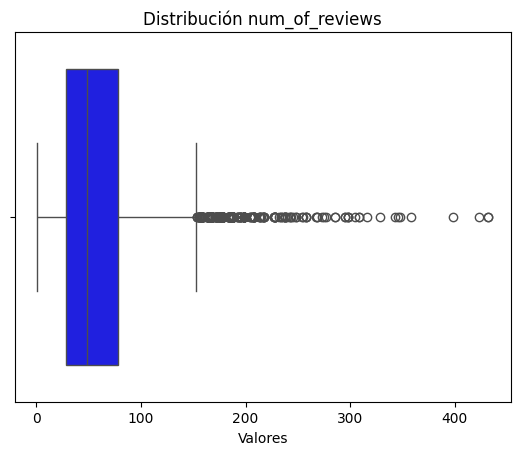

In [106]:
# Crear el gráfico de caja
sns.boxplot(x=df_maps_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

Y decidimos eliminar datos que no sean representativos, siendo estos aquellos que posean mas de 160. Recortando asi un 3% `256` de los datos que poseiamos `9489`

In [107]:
df_maps_restaurantes.drop(df_maps_restaurantes[df_maps_restaurantes['num_of_reviews'] > 160].index, inplace=True) # saco 256 registros de 9489 equivale al 3%

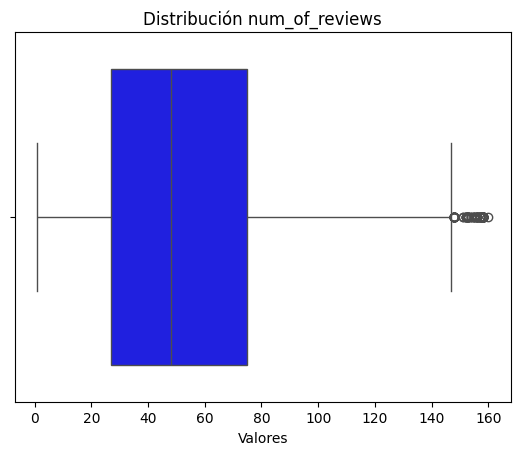

In [108]:
# Crear el gráfico de caja
sns.boxplot(x=df_maps_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

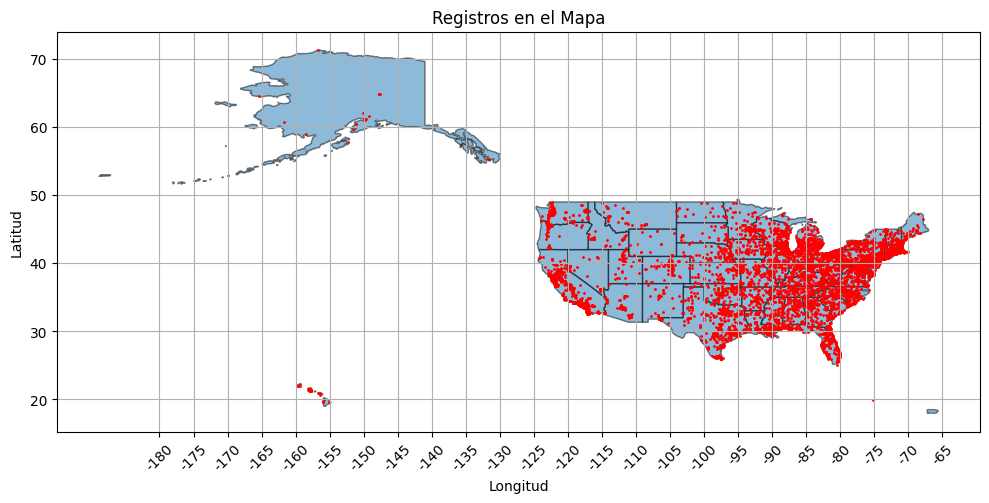

In [109]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_maps_restaurantes, geometry=gpd.points_from_xy(df_maps_restaurantes['longitude'], df_maps_restaurantes['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

In [110]:
df_maps_restaurantes.loc[(df_maps_restaurantes['latitude'] < 21) & (df_maps_restaurantes['longitude'] < -70) & (df_maps_restaurantes['longitude'] > -80)]

,name,address,gmap_id,description,latitude,longitude,category,avg_rating,num_of_reviews,price,hours,MISC,state,relative_results,url
139328,Subway,"Subway, Sherman Ave",0x8ececf93aaa3553b:0x80d37fdf4ff72429,Casual counter-serve chain for build-your-own ...,19.916014,-75.139875,"[Sandwich shop, Restaurant]",4.0,55,$,"[[Monday, 6AM–10PM], [Tuesday, 6AM–10PM], [Wed...",{'Accessibility': ['Wheelchair accessible entr...,Closed ⋅ Opens 6AM,"[0x8ececfc0e847f4b1:0x3032c5de29d5e2b, 0x8ecec...",https://www.google.com/maps/place//data=!4m2!3...


Buscando en google la direccion me devuelve las correctas coordenadas del local

In [111]:
df_maps_restaurantes.loc[df_maps_restaurantes['gmap_id'] == "0x8ececf93aaa3553b:0x80d37fdf4ff72429", 'latitude'] = 43.127694
df_maps_restaurantes.loc[df_maps_restaurantes['gmap_id'] == "0x8ececf93aaa3553b:0x80d37fdf4ff72429", 'longitude'] = -89.363469

## Cruze de tablas

Filtramos las reviews dejando solo las que pertenecen a los locales que quedaron luego del tratamiento de outliers

In [112]:
restaurantes = df_maps_restaurantes['gmap_id'].to_list()
df_maps_reviews = df_maps_reviews[df_maps_reviews['gmap_id'].isin(restaurantes)]
df_maps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39240 entries, 226 to 2389575
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           39240 non-null  object 
 1   name_x            39240 non-null  object 
 2   time              39240 non-null  int64  
 3   rating            39240 non-null  int64  
 4   text              18995 non-null  object 
 5   pics              461 non-null    object 
 6   resp              105 non-null    object 
 7   gmap_id           39240 non-null  object 
 8   anio              39240 non-null  int64  
 9   estado            39240 non-null  object 
 10  name_y            39240 non-null  object 
 11  address           39240 non-null  object 
 12  description       39210 non-null  object 
 13  latitude          39240 non-null  float64
 14  longitude         39240 non-null  float64
 15  category          39240 non-null  object 
 16  avg_rating        39240 non-null  float64

## df_maps_reviews

In [113]:
df_maps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39240 entries, 226 to 2389575
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           39240 non-null  object 
 1   name_x            39240 non-null  object 
 2   time              39240 non-null  int64  
 3   rating            39240 non-null  int64  
 4   text              18995 non-null  object 
 5   pics              461 non-null    object 
 6   resp              105 non-null    object 
 7   gmap_id           39240 non-null  object 
 8   anio              39240 non-null  int64  
 9   estado            39240 non-null  object 
 10  name_y            39240 non-null  object 
 11  address           39240 non-null  object 
 12  description       39210 non-null  object 
 13  latitude          39240 non-null  float64
 14  longitude         39240 non-null  float64
 15  category          39240 non-null  object 
 16  avg_rating        39240 non-null  float64

### `avg_rating`

Comprobamos que no haya datos fuera del rango (1:5)

In [114]:
df_maps_reviews['avg_rating'].value_counts()

avg_rating
3.9    5191
4.0    4599
4.2    4099
3.8    3904
4.1    3898
3.7    3087
3.6    2912
4.3    2422
3.5    2136
3.4    1637
3.3    1227
4.4    1197
3.2     780
3.1     433
3.0     364
4.6     215
2.8     210
4.5     197
2.9     180
2.7     174
2.6     111
2.5      80
2.3      55
4.7      49
2.4      37
2.0      15
2.2      11
1.8      10
4.9      10
Name: count, dtype: int64

### ``num_of_reviews``

Observamos la distribución de la columna `num_of_reviews`

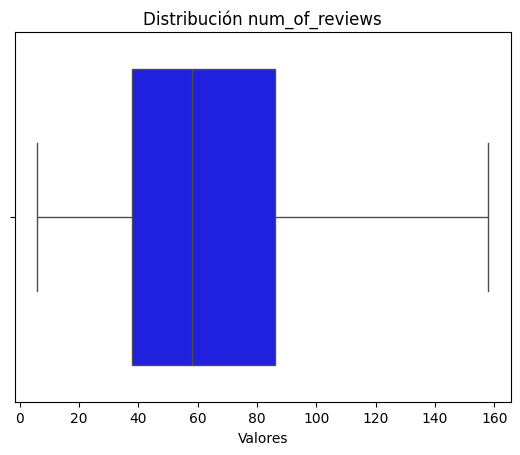

In [115]:
# Crear el gráfico de caja
sns.boxplot(x=df_maps_reviews['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

Y decidimos eliminar datos que no sean representativos, siendo estos aquellos que posean mas de 160. Recortando asi un 3% `256` de los datos que poseiamos `9489`

In [116]:
df_maps_restaurantes.drop(df_maps_restaurantes[df_maps_restaurantes['num_of_reviews'] > 160].index, inplace=True) # saco 256 registros de 9489 equivale al 3%

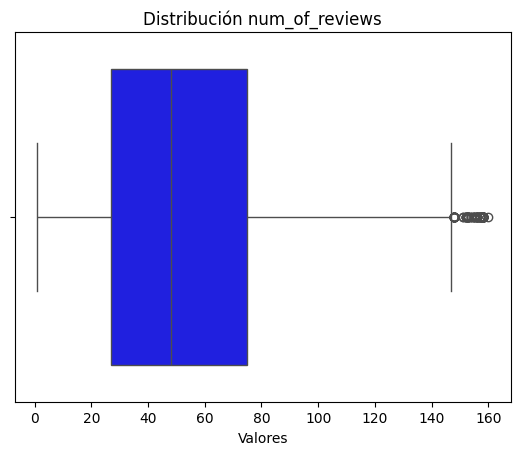

In [117]:
# Crear el gráfico de caja
sns.boxplot(x=df_maps_restaurantes['num_of_reviews'], color='blue')

# Añadir etiquetas y título
plt.xlabel('Valores')
plt.title('Distribución num_of_reviews')

# Mostrar el gráfico
plt.show()

### ``latitude`` y ``longitude``

Graficamos los datos en un mapa de USA en busca de registros con coordenadas atipicas

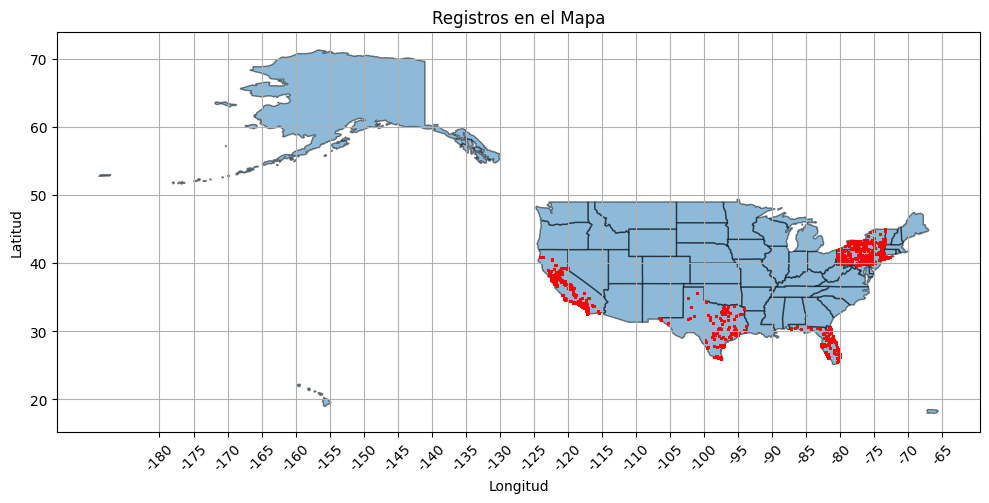

In [118]:
# Cargar los datos geoespaciales del mapa GeoJSON
usa_geojson = 'Geojson/us-states.json'
usa_gpd = gpd.read_file(usa_geojson)

# Crear un GeoDataFrame con los registros de tus datos
registros_gdf = gpd.GeoDataFrame(df_maps_reviews, geometry=gpd.points_from_xy(df_maps_reviews['longitude'], df_maps_reviews['latitude']))

# Crear el subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plotear los barrios en el mapa
usa_gpd.plot(ax=ax, edgecolor='black', alpha=0.5)

# Plotear los registros en el mapa
registros_gdf.plot(ax=ax, color='red', markersize=1)

# Ajustar diseño
plt.title('Registros en el Mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')

# Agregar líneas de división y más valores en el eje horizontal (longitud)
ax.set_xticks(range(-180, -60, 5))  # Establece las marcas en intervalos de 5 grados
ax.set_xticklabels(range(-180, -60, 5), rotation=45)  # Etiquetas rotadas para una mejor legibilidad

# Agregar líneas de división en los ejes x e y
ax.grid(True)

plt.tight_layout()

# Mostrar el mapa
plt.show()

# Tipos de datos

## df_maps_restaurantes

In [119]:
df_maps_restaurantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9234 entries, 124 to 212005
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              9234 non-null   object 
 1   address           9234 non-null   object 
 2   gmap_id           9234 non-null   object 
 3   description       9173 non-null   object 
 4   latitude          9234 non-null   float64
 5   longitude         9234 non-null   float64
 6   category          9234 non-null   object 
 7   avg_rating        9234 non-null   float64
 8   num_of_reviews    9234 non-null   int64  
 9   price             9175 non-null   object 
 10  hours             9114 non-null   object 
 11  MISC              9234 non-null   object 
 12  state             9114 non-null   object 
 13  relative_results  8779 non-null   object 
 14  url               9234 non-null   object 
dtypes: float64(3), int64(1), object(11)
memory usage: 1.1+ MB


Cambiamos el tipo de datos de las columnas `avg_rating`, `num_of_reviews` y `price` para reducir el uso de memoria a cambio de precisiòn innecesaria en los datos

In [120]:
df_maps_restaurantes['avg_rating'] = df_maps_restaurantes['avg_rating'].astype('float32')

df_maps_restaurantes['num_of_reviews'] = df_maps_restaurantes['num_of_reviews'].astype('int32')

df_maps_restaurantes['price'] = df_maps_restaurantes['price'].astype('category')

## df_maps_reviews

In [123]:
print(df_maps_reviews.info())

<class 'pandas.core.frame.DataFrame'>
Index: 39240 entries, 226 to 2389575
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   user_id           39240 non-null  object  
 1   name_x            39240 non-null  object  
 2   time              39240 non-null  int64   
 3   rating            39240 non-null  int8    
 4   text              18995 non-null  object  
 5   pics              461 non-null    object  
 6   resp              105 non-null    object  
 7   gmap_id           39240 non-null  object  
 8   anio              39240 non-null  category
 9   estado            39240 non-null  category
 10  name_y            39240 non-null  object  
 11  address           39240 non-null  object  
 12  description       39210 non-null  object  
 13  latitude          39240 non-null  float64 
 14  longitude         39240 non-null  float64 
 15  category          39240 non-null  object  
 16  avg_rating        39240

Cambiamos el tipo de datos de las columnas para reducir el uso de memoria.

In [122]:
# Convertir 'rating' a int8
df_maps_reviews_copy = df_maps_reviews.copy()
df_maps_reviews_copy['rating'] = df_maps_reviews_copy['rating'].astype('int8')

# Convertir 'num_of_reviews' a int32
df_maps_reviews_copy['num_of_reviews'] = df_maps_reviews_copy['num_of_reviews'].astype('int32')

# Convertir 'price' a category
df_maps_reviews_copy['price'] = df_maps_reviews_copy['price'].astype('category')

# Convertir 'anio' a category
df_maps_reviews_copy['anio'] = df_maps_reviews_copy['anio'].astype('category')

# Convertir 'estado' a category
df_maps_reviews_copy['estado'] = df_maps_reviews_copy['estado'].astype('category')

# Convertir 'avg_rating' a float32
df_maps_reviews_copy['avg_rating'] = df_maps_reviews_copy['avg_rating'].astype('float32')

# Convertir 'state_ab' a category
df_maps_reviews_copy['state_ab'] = df_maps_reviews_copy['state_ab'].astype('category')

# Convertir 'us_state' a category
df_maps_reviews_copy['us_state'] = df_maps_reviews_copy['us_state'].astype('category')

# Asignar la copia modificada al DataFrame original
df_maps_reviews = df_maps_reviews_copy